In [39]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [27]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [28]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    
    return df

In [29]:
train = process_df(train)
holdout = process_df(holdout)

In [30]:
train[["SibSp", "Parch"]].dtypes

SibSp    int64
Parch    int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f44b82a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8f44ad06a0>]], dtype=object)

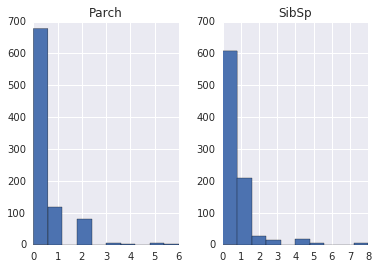

In [31]:
train[["SibSp", "Parch"]].hist()

In [32]:
 train.pivot_table(values="Survived", index="SibSp")

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [33]:
 train.pivot_table(values="Survived", index="Parch")

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

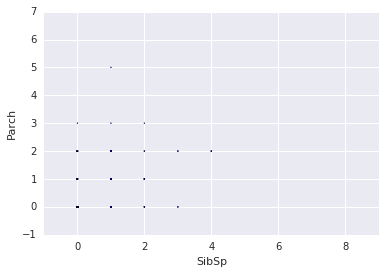

In [34]:
# pt =  train.pivot_table(values="Survived", index=["Parch", "SibSp"])
# pt
plt.scatter(x=train["SibSp"], y=train["Parch"], s=train["Survived"])
plt.xlabel("SibSp")
plt.ylabel("Parch")
plt.show()

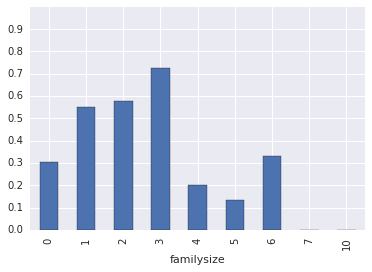

In [35]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize', values="Survived")
pivot.plot.bar(ylim=(0, 1), yticks=np.arange(0, 1 , 0.1))
plt.show()

In [36]:
def add_isalone(df):
    df["isalone"] = df.apply(lambda row: 1 if row["SibSp"]==0 and row["Parch"]==0 else 0, 
                             axis=1)
    return df
    
train = add_isalone(train)
holdout = add_isalone(holdout)

In [37]:
def select_features(df):
    all_X = df.select_dtypes(include=[np.number])
    all_X = all_X.drop(labels=["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    estimator = RandomForestClassifier(random_state=1)
    selector = RFECV(estimator, cv=10)
    selector = selector.fit(all_X, all_y)
    
    return all_X.columns[selector.support_]

cols = select_features(train)
cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

In [42]:
def select_model(df, features):
    all_X = df[features]
    all_y = df["Survived"]
    
    params = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        }
    ]
    
    for p in params:
        print(p['name'])
        search = GridSearchCV(p['estimator'], param_grid=p['hyperparameters'], cv=10)
        search.fit(all_X, all_y)
        p["best_score"] = search.best_score_ 
        p["best_params"] = search.best_params_ 
        p["best_estimator"] = search.best_estimator_
        print("best params:", p["best_params"], "best score:", p["best_score"])
    
    return params

models = select_model(train, cols)

LogisticRegression
best params: {'solver': 'liblinear'} best score: 0.820426487093
KNeighborsClassifier
best params: {'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'brute', 'p': 1} best score: 0.775533108866
RandomForestClassifier
best params: {'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 6, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_leaf': 1} best score: 0.837261503928


In [45]:
def save_submission_file(estimator, cols, filename="submission.csv"):
    predictions = estimator.predict(holdout[cols])
    submission_df = {"PassengerId":holdout["PassengerId"], "Survived":predictions}
    df = pd.DataFrame(submission_df)
    df.to_csv(filename, index=False)
    
for i, v in enumerate(models):
    save_submission_file(v['best_estimator'], cols, "submission"+str(i)+".csv")

next steps:

-Continue to explore the data and create new features, following the workflow and using the functions we created.
-Read more about the titanic and this Kaggle competition to get ideas for new features.
-Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.